# **Cognition and Computation Final Project (2022/2023)**
---------------------------------
```
 _______________________________________________________
| StudentID |  Firstname   |  Lastname  |     Degree    |
|___________|______________|____________|_______________|
|           |              |            | Cybersecurity |
|___________|______________|____________|_______________|

```



\
___________________________
In this project, I will be using the EMNIST dataset, specifically the digits set, to perform various experiments to better understand the behavior and performance of a deep neural network. Our main objective is to explore the internal representations developed by the model and how they change as I progress through the different layers. To accomplish this, I will perform linear read-outs at various levels of the network hierarchy to observe if the sensory representations become more disentangled in the deeper layers.

\
In addition to exploring the internal representations, I will also be analyzing the kinds of errors made by the model. To do so, I will create confusion matrices and psychometric curves, which can be generated by adding increasing amounts of noise to the test data. This will provide us with valuable insight into the strengths and weaknesses of the model.

\
Furthermore, I will also be investigating the network's ability to handle adversarial attacks. Adversarial attacks are designed to deliberately mislead the model, and they are an important consideration in the development of robust and secure deep learning systems. By exploring the response of the network to these attacks, I will gain a better understanding of its robustness and what can be done to improve it.

\
Finally, I will also be examining the network's capability of few-shot learning, which refers to its ability to generalize from only a few examples. This is a critical aspect of deep learning as it allows the network to learn new concepts with limited training data. By exploring this, I will get a better understanding of the model's ability to generalize, and what can be done to improve it.

__________

In [ ]:
repo = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"

# Check if the DBN and RBM files exist or not.
try:
    from DBN import DBN
except ImportError:
    files = ["DBN.py", "RBM.py"]
    for file in files:
        ! wget -O {file} {repo}{file}
    from DBN import DBN

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision as tv

from DBN import DBN

________
Check if the GPU is available or not, to use that for Pytorch.
Let's choose dynamically the kind of device used for computations (CPU or GPU).


In [ ]:
print(f"[ Using GPU >>>>> {torch.cuda.is_available()} ]")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

[ Using GPU >>>>> True ]


_____
## **Download the EMNIST dataset and store in data/ directory.**

- This code block downloads the EMNIST Digits dataset, split into two sets: the training set (emnist_train) and the test set (emnist_test).
- The split argument specifies which part of the EMNIST dataset to download, in this project, I will use the 'digits' set.
- The transform argument specifies a list of transformations to apply to the dataset. In this case, the ToTensor transformation from the torchvision.transforms module is applied, which converts the images from the original format to a PyTorch tensor.


In [ ]:
%%capture
emnist_train = tv.datasets.EMNIST('data/', train=True, download=True, split='digits',
                                         transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()]
                                         ))

emnist_test = tv.datasets.EMNIST("data/",
                                train=False,
                                download=True,
                                split='digits',
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor()]
                                ))


__________________

- The following cell normalizes the pixel values of the EMNIST Digits dataset by dividing each pixel value by 255.
- The **type** method is used to convert the data type of the images from the original format to torch.FloatTensor. This is necessary because the normalization operation requires floating-point arithmetic, and the original format may not support floating-point arithmetic.
- After conversion, each pixel value is divided by 255, which scales the values from the original range of [0, 255] to a new range of [0, 1]. This normalization step is common in computer vision tasks as it helps to ensure that the model does not assign too much importance to large pixel values and improves the stability of the optimization process.

In [ ]:
emnist_train.data = (emnist_train.data.type(torch.FloatTensor)/255)
emnist_test.data = (emnist_test.data.type(torch.FloatTensor)/255)

______
- The following cell moves the data and targets of the EMNIST Digits dataset to the specified device, which is stored in the device variable.

- The **data.to(device)** method is used to transfer the data and targets to the device, which could be either the CPU or GPU, depending on what is specified in the device variable. This is necessary because many machine learning libraries, including PyTorch, require that data and parameters be stored on the same device for efficient computation.

- By moving the data and targets to the specified device, this code block enables the model to perform computations on either the CPU or GPU, depending on the availability and the specified device. This can significantly speed up the training process, especially when working with large datasets and complex models.

In [ ]:
emnist_train.data = emnist_train.data.to(device)
emnist_test.data = emnist_test.data.to(device)
emnist_train.targets = emnist_train.targets.to(device)
emnist_test.targets = emnist_test.targets.to(device)

_____
## **Initializes an instance of the Deep Belief Network (DBN) model.**

The DBN class is imported from an external library and takes several parameters as input to configure the model. The parameters specified in this code cell are:
- **visible_units**: This specifies the number of input nodes in the model, which is equal to the number of features in the input data. For the EMNIST Digits dataset, each image has 28x28 pixels, so the number of visible units is 28x28 = 784.
- **hidden_units**: This is a list of integers that specifies the number of hidden units in each hidden layer of the model. In this case, the model has three hidden layers with 500, 600, and 700 units respectively.
- **k**: This is the number of Gibbs sampling steps to perform during the contrastive divergence training procedure.
- **learning_rate**: This is the learning rate used by the optimization algorithm during training.
- **learning_rate_decay**: This is a flag that determines whether the learning rate should decrease over time during training.
- **initial_momentum**: This is the initial value of the momentum used by the optimization algorithm during training.
- **final_momentum**: This is the final value of the momentum used by the optimization algorithm during training.
- **weight_decay**: This is the weight decay regularization term used to prevent overfitting during training.
- **xavier_init**: This is a flag that determines whether the model weights should be initialized using the Xavier initialization method.
- **increase_to_cd_k**: This is a flag that determines whether the number of Gibbs sampling steps should be gradually increased during training.
- **use_gpu**: This is a flag that determines whether the model should use the GPU for computations. It is set to torch.cuda.is_available(), which means that it will use the GPU if it is available, and the CPU otherwise.

This cell creates an instance of the DBN model with the specified parameters, which can then be used for training and evaluation.

In [ ]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[500, 600, 900],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

________
## **Training the model**
- This section of code is training a Deep Belief Network (DBN) model using the EMNIST digits dataset.

- **dbn_emnist** is the object of DBN class, with specified hyperparameters (such as number of hidden units, learning rate, momentum, weight decay, etc.).

- The **train_static** method trains the model with given training data (emnist_train.data) and corresponding labels (emnist_train.targets) for num_epochs iterations, in mini-batches of size batch_size.

In [ ]:
num_epochs = 50
batch_size = 125

dbn_emnist.train_static(
    emnist_train.data,
    emnist_train.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.1435     |0.0352       |319.8676   |5.4308     |
|20    |1.1181     |0.0344       |312.1163   |5.0528     |
|30    |1.1123     |0.0345       |309.0944   |4.9867     |
|40    |1.1097     |0.0341       |307.8460   |5.0232     |
|50    |1.1095     |0.0341       |307.9136   |5.2344     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.1360     |0.0317       |236.3822   |3.1713     |
|20    |1.1149     |0.0316       |233.2210   |3.0406     |
|30    |1.1090     |0.0309       |231.7550   |2.8359     |
|40    |1.1050     |0.0314       |230.6251   |2.7438     |
|50    |1.1041     |0.0317       |230.0648   |2.9573     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.8215     |0.0252       |254.0760   |3.6929     |
|20    |0.7927     |0.0244       |248.3108   |3.490

The output is the training statistics with multiple Restricted Boltzmann Machines (RBMs) layers.

- The table shows the statistics of each RBM layer at different training epochs (iterations).
- For each RBM layer, there are 5 metrics displayed:
    - Epoch: The number of training iterations completed.
    - avg_rec_err: The average reconstruction error, a measure of how well the RBM can reconstruct the input. Lower values mean the model is reconstructing the inputs better.
    - std_rec_err: The standard deviation of reconstruction error.
    - mean_grad: The average gradient, a measure of the change in the model's parameters during training.
    - std_grad: The standard deviation of the gradient.

As the training progresses, the reconstruction error for each RBM layer decreases and the mean gradient values change. The standard deviation of reconstruction error and gradient also change, indicating the model's training dynamics.


_______
## **Linear read-out**
- I first trained the DBN using the `train_static` method in the previous cell, which trains the DBN in an unsupervised manner. Then, the code trains 3 linear models (linear1, linear2, linear3) using the representations learned by the DBN in each layer, in a supervised manner. After training, the accuracy of each of the 3 linear models is computed on the test set of the EMNIST dataset.
- The **get_kth_layer_repr** function takes an input tensor and returns the representation of the input in the k-th layer of the DBN.
- The train function trains a network using the Stochastic Gradient Descent (SGD) optimization algorithm with a learning rate of 0.05 and a cross-entropy loss function. The function trains the network for 1500 epochs and prints the loss every 100 epochs.
- The final accuracy is computed using the **compute_accuracy** function, which computes the accuracy by comparing the predicted labels to the true labels.

**In summary:** By propagating neuron activations from the sensory (visible) layer in a bottom-up manner, we were able to extract the hidden representations of the data and attempt to linearly decode the content of the representations in a supervised manner.

\
> ### ***- There are also comments in the code that explain what each line does.***
\

In [ ]:
def get_kth_layer_repr(input, k, device):
  # convert the input to flattened tensor, change the data type to FloatTensor, and move to the device specified
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  # pass the flattened input through the kth layer of the DBN to obtain the hidden representation
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)
  return hidden_repr

In [ ]:
# get the hidden representation from the first layer of the DBN
hidden_repr_layer_1 = get_kth_layer_repr(emnist_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

In [ ]:
# define the linear model that takes the last layer representation and outputs predictions for 10 classes
class LinearModel(torch.nn.Module):
  def __init__(self, last_layer_size):
    super().__init__()
    # a linear layer that takes the last layer representation as input and outputs predictions for 10 classes
    self.linear = torch.nn.Linear(last_layer_size, 10)

  def forward(self, x):
    return self.linear(x)

In [ ]:
# get the size of the representation from the first layer of the DBN
layer_size = dbn_emnist.rbm_layers[0].W.shape[1]
# create an instance of the linear model with the size of the representation from the first layer
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

In [ ]:
# function to train a network
def train(network, input, epochs=1500):
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  # loss function used to compute the loss during training
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad() # reset the gradient before each epoch
    predictions = network(input).squeeze() # make predictions using the network
    targets = emnist_train.targets.reshape(predictions.shape[0])  # retrieve the true targets/labels
    loss = loss_fn(predictions, targets) # calculate the loss between the predictions and targets
    loss.backward() # perform backpropagation to calculate the gradients of the loss w.r.t. network parameters
    optimizer.step() # update the network parameters using optimizer step

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}  , loss = {:.4f}".format(epoch + 1, epochs, loss))  # log the loss for every 100 epochs


In [ ]:
print("Working on Layer 1:")
train(linear1, hidden_repr_layer_1)
print("\n\nWorking on Layer 2:")
train(linear2, hidden_repr_layer_2)
print("\n\nWorking on Layer 3:")
train(linear3, hidden_repr_layer_3)

Working on Layer 1:
epoch :   1/1500  , loss = 2.2856
epoch : 101/1500  , loss = 0.7192
epoch : 201/1500  , loss = 0.4871
epoch : 301/1500  , loss = 0.3960
epoch : 401/1500  , loss = 0.3452
epoch : 501/1500  , loss = 0.3120
epoch : 601/1500  , loss = 0.2882
epoch : 701/1500  , loss = 0.2700
epoch : 801/1500  , loss = 0.2555
epoch : 901/1500  , loss = 0.2437
epoch : 1001/1500  , loss = 0.2337
epoch : 1101/1500  , loss = 0.2251
epoch : 1201/1500  , loss = 0.2177
epoch : 1301/1500  , loss = 0.2112
epoch : 1401/1500  , loss = 0.2053


Working on Layer 2:
epoch :   1/1500  , loss = 2.3346
epoch : 101/1500  , loss = 0.7055
epoch : 201/1500  , loss = 0.4855
epoch : 301/1500  , loss = 0.3983
epoch : 401/1500  , loss = 0.3494
epoch : 501/1500  , loss = 0.3172
epoch : 601/1500  , loss = 0.2941
epoch : 701/1500  , loss = 0.2764
epoch : 801/1500  , loss = 0.2624
epoch : 901/1500  , loss = 0.2508
epoch : 1001/1500  , loss = 0.2411
epoch : 1101/1500  , loss = 0.2328
epoch : 1201/1500  , loss = 0.225

The output shows the training process of three layers, labeled as "Layer 1", "Layer 2", and "Layer 3". For each layer, the model trains 1500 epochs and calculates the loss after each epoch. The loss value represents the difference between the predicted output and the actual output. As the training progresses, the loss value decreases, which indicates that the model is learning and improving its predictions. From the output, it can be observed that the loss values decrease more rapidly in the later epochs, indicating that the model has learned most of the patterns in the data. Additionally, it can be seen that the loss values for Layer 3 are lower compared to Layer 1 and Layer 2, implying that the model is better at predicting the output for Layer 3.

In [ ]:
# Get the representation of the test data for each layer
hidden_repr_layer_1_test = get_kth_layer_repr(emnist_test.data, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)

In [ ]:
# Compute the predictions on the test data for each layer
predictions_test1 = linear1(hidden_repr_layer_1_test)
predictions_test2 = linear2(hidden_repr_layer_2_test)
predictions_test3 = linear3(hidden_repr_layer_3_test)

In [ ]:
# Compute the accuracy of the predictions on the test data for each layer
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  # Compute the number of correct predictions
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

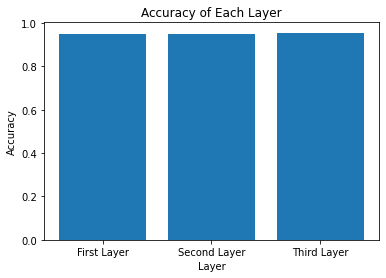


Accuracy of first layer   :  0.9496749639511108
Accuracy of second layer  :  0.9475999474525452
Accuracy of third layer   :  0.9558249711990356


In [ ]:
accuracies = [compute_accuracy(predictions_test1, emnist_test.targets),
              compute_accuracy(predictions_test2, emnist_test.targets),
              compute_accuracy(predictions_test3, emnist_test.targets)
              ]
layer_names = ['First Layer', 'Second Layer', 'Third Layer']

plt.bar(layer_names, accuracies)
plt.ylabel('Accuracy')
plt.xlabel('Layer')
plt.title('Accuracy of Each Layer')
plt.show()

print("\nAccuracy of first layer   : ", compute_accuracy(predictions_test1, emnist_test.targets))
print("Accuracy of second layer  : ", compute_accuracy(predictions_test2, emnist_test.targets))
print("Accuracy of third layer   : ", compute_accuracy(predictions_test3, emnist_test.targets))

This output suggests that the deeper layers are performing better in terms of accuracy compared to the first layer.

____________
## **Comparison with a feed-forward model**
Let's now train a simple feed-forward neural network with the same structure of the DBN, in order to compare a non-linear model that is trained end-to-end to solve a classification task with a simple linear classifier that solves the same task using representations of input data learned in an *unsupervised* way.

In [ ]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 10)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [ ]:
ffnn = Feedforward(400, 500, 800).to(device)

We choose the number of epochs to match the training time of the DBN and the readout layer combined.

In [ ]:
train(ffnn, emnist_train.data.reshape((240000, 784)), epochs=1500)

epoch :   1/1500  , loss = 2.3037
epoch : 101/1500  , loss = 2.1229
epoch : 201/1500  , loss = 0.7550
epoch : 301/1500  , loss = 0.3996
epoch : 401/1500  , loss = 0.3270
epoch : 501/1500  , loss = 0.2934
epoch : 601/1500  , loss = 0.2710
epoch : 701/1500  , loss = 0.2536
epoch : 801/1500  , loss = 0.2389
epoch : 901/1500  , loss = 0.2260
epoch : 1001/1500  , loss = 0.2144
epoch : 1101/1500  , loss = 0.2038
epoch : 1201/1500  , loss = 0.1942
epoch : 1301/1500  , loss = 0.1854
epoch : 1401/1500  , loss = 0.1772


In [ ]:
predictions_ffnn = ffnn(emnist_test.data.reshape((40000, 784)))

In [ ]:
compute_accuracy(predictions_ffnn, emnist_test.targets)

0.9513999819755554

_________
## **Robustness to noise**


*   The `inject_noise` function takes in `emnist_data`, a tensor of grayscale images, and `noise_level` as inputs, and adds random Gaussian noise with standard deviation noise_level to the data. The function returns the emnist_data with added noise.

This, like what happens in psychophysical tests, will allow us to develop a psychometric curve that describes the decline in classification accuracy as a function of noise level.

In [ ]:
  def inject_noise(emnist_data, noise_level):
    random_gaussian_tensor = torch.randn(emnist_data.shape, device = device)*noise_level
    return emnist_data + random_gaussian_tensor

_______________
*   The `emnist_test_with_noise` is created by calling the `inject_noise` function with `emnist_test.data` and `noise_level`. The last line displays the first image of emnist_test_with_noise after reshaping it back to 28x28 pixels and converting it to CPU for display purposes.
-   This cell will show the original and after noise picture

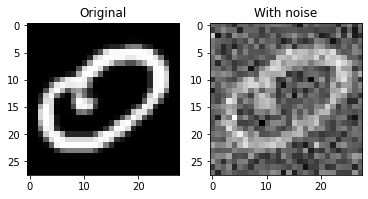

In [ ]:
noise_level = 0.3

# show the original image
plt.subplot(1, 2, 1)
plt.title("Original")
__ = plt.imshow(emnist_test.data[0].reshape(28, 28).to("cpu"), cmap="gray")


# show the image after adding noise
# I'll now introduce some noise into the input pictures to observe how resistant the DBN and feed-forward network representations are to changes in the sensory data.
emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)
plt.subplot(1, 2, 2)
plt.title("With noise")
__ = plt.imshow(emnist_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")

plt.show()
# emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)
# __ = plt.imshow(emnist_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")

_____
The following cell defines a function `get_accuracy_values_at_noise_level()` which takes a noise_level argument and returns 4 accuracy values.

1.   It first generates noisy test images from the `emnist_test.data` by calling the `inject_noise()` function with the noise_level argument.
2.   Then, it computes the Deep Belief Network (DBN) representations of the noisy test images by `calling the get_kth_layer_repr()` function 3 times, each time using the output from the previous call as the input, and store the results in hidden_repr_layer_1_noisy, hidden_repr_layer_2_noisy, and hidden_repr_layer_3_noisy.
3. It then uses the previously trained read-out classifiers, linear1, linear2, and linear3, to make predictions on the representations obtained in the previous step and store the results in predictions_first_hidden_noisy, predictions_second_hidden_noisy, and predictions_third_hidden_noisy.

\
The accuracy of each of the above predictions is computed by calling the `compute_accuracy()` function, which takes two arguments:
1. the predictions
2. the true labels stored in `emnist_test.targets`.

The results are stored in accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden.

\
**Finally**, the code repeats a similar process for a feed-forward neural network model, ffnn, by reshaping emnist_test_with_noise and using it to make predictions, computing the accuracy of the predictions with `compute_accuracy()`, and storing the result in accuracy_ffnn.


In [ ]:
def get_accuracy_values_at_noise_level(noise_level):

  emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)  # first, let's create noisy test images

  hidden_repr_layer_1_noisy = get_kth_layer_repr(emnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)

  predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)

  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, emnist_test.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, emnist_test.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, emnist_test.targets)

  predictions_ffnn_noisy = ffnn(emnist_test_with_noise.reshape((40000, 784)))  # we repeat a similar process for the feed-forward model
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, emnist_test.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

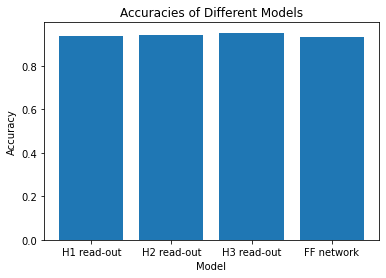


Accuracy of H1 read-out   : 0.936
Accuracy of H2 read-out   : 0.941
Accuracy of H3 read-out   : 0.951
Accuracy of FF network    : 0.930


In [ ]:
acc = get_accuracy_values_at_noise_level(0.3);

accuracies = [acc[0], acc[1], acc[2], acc[3]]
labels = ['H1 read-out', 'H2 read-out', 'H3 read-out', 'FF network']
plt.bar(labels, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracies of Different Models')
plt.show()

print("\nAccuracy of H1 read-out   : %.3f" % acc[0])
print("Accuracy of H2 read-out   : %.3f" % acc[1])
print("Accuracy of H3 read-out   : %.3f" % acc[2])
print("Accuracy of FF network    : %.3f" % acc[3])

The models are a read-out layer for 3 hidden layers (H1, H2, H3) and a feedforward network (FF network). The highest accuracy was achieved by the H3 read-out layer, with a score of 0.951.

______
## **Create the psychometric curves for the DBN and for the feed-forward network:**

The following cells are plotting a robustness curve of four different neural network models to various levels of noise.
1. It first defines an empty list accuracy_values_first_hidden, accuracy_values_second_hidden, accuracy_values_third_hidden, and accuracy_values_ffnn to store the accuracy of each of the models at each noise level.

2. In the for-loop, it iterates over each noise level in the `noise_levels` list, and calls the `get_accuracy_values_at_noise_level` function to get the accuracy of each model at the current noise level. The returned accuracy is a 4-element tuple and is appended to the appropriate accuracy list.

3. Finally, the code uses matplotlib to plot the accuracy values for each model against the corresponding noise level. The x-axis represents the noise level, and the y-axis represents the accuracy.

In [ ]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

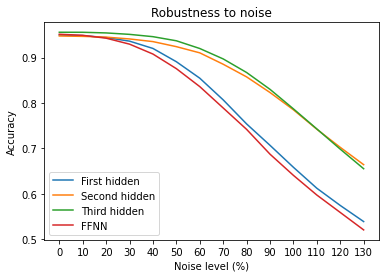

In [ ]:

def plot_confusion_matrix(y_true, y_pred):
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(confusion_matrix, annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.show()

def plot_classification_report(y_true, y_pred):
    report = metrics.classification_report(y_true, y_pred, target_names=list(map(str, range(10))))
    print("Classification Report:")
    print(report)


noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)

The results show that the third and second level models have a better accuracy than the first level and the FFNN, which experience a significant drop in accuracy when the noise level increases, mostly after 40% to 130% of noise level. The chart highlights the effect of the increasing noise levels on the accuracy of the models and demonstrates the robustness of the third and second level models in comparison to the first level and FFNN.

_______
## **Perturbing the models with adversarial attacks**
### Fast gradient sign method

- Adversarial attacks are a specific type of attack on models where the goal is to manipulate the input data in such a way that the model's predictions are significantly changed, even though the modifications made to the input may seem minor and undetectable to the human eye. The attack works by carefully choosing the modifications to the input in order to maximize the loss for that particular input. In other words, the goal of the adversarial attack is to trick the model into making incorrect predictions, by making small changes to the input that the model is not able to correctly process. This highlights the vulnerability of machine learning models to such attacks and the need to develop robust models that can handle adversarial examples in a robust manner.


- The loss is a measure of how well the model is performing in its prediction tasks. The calculation of the loss is performed by comparing the predicted output values of the model for a given input to the true output labels. The loss function is designed to give a numerical score that reflects the difference between the predicted and true values. This difference is used to optimize the model parameters, $w$, such that the model can minimize the loss and improve its prediction accuracy. In essence, the loss function provides a direction for the model to update its parameters and improve its predictions. The loss function is an important component in the training process of machine learning models.

- The loss is typically calculated as a function of the input, model parameters, and outputs: $J(w, x, y)$.


\
\
In order to create an adversarial sample, we need to know the direction in which the loss function increases, which is the direction of the gradient. Instead of updating the model's weights as we normally would during training, we modify the input to increase the loss. By doing so, the model will be more likely to produce an incorrect prediction on the adversarial sample, meaning that the input has been successfully perturbed to trick the model. This technique of modifying the input to create an adversarial sample is a common way of evaluating the robustness of a machine learning model. By creating adversarial samples, we can test the limits of a model's generalization ability, and determine if the model is overfitting or underfitting.


In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

__________
## **Adversarial samples**

The `DBNWithReadOut` class is a subclass of the `torch.nn.Module` class, which is a base class for building neural network modules in PyTorch.

1. The `__init__` method of the DBNWithReadOut class initializes the class by taking in a pre-trained DBN dbn_emnist, a list of readout layers readouts, and the desired readout level readout_level.
2. The `_require_grad` method sets the gradients to be computed for the weight and bias parameters of each layer in the DBN.

3. The forward method implements the forward pass of the DBN with readout layer, which takes an image as input, and returns the prediction for the image. In the forward pass, the input image is first transformed through each of the RBM layers in the DBN, and the hidden activations at the desired readout level are returned. The desired readout level is determined by the readout_level argument passed to the DBNWithReadOut class.

4. The `readout_level` argument is set to 2, meaning the prediction will be based on the hidden activations at the 2nd readout layer in the readouts list.

In [ ]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_emnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_emnist = dbn_emnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_emnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_emnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])


dbn_with_readout = DBNWithReadOut(dbn_emnist, [linear1, linear2, linear3], readout_level=2)


Let's take a look at an adversiarial sample. Take just one sample from the test set:

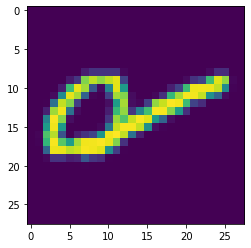

In [ ]:
test_sample_idx = 1
test_image = emnist_test.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'))

Let's use one of the previously trained models to classify this "clean" image before modifying it to attack the network.

In [ ]:
attacked_model = ffnn
attacked_model = dbn_with_readout

test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is: {prediction}")

The prediction of the model for this clean sample is: 9


- The following cell performs an adversarial attack using Fast Gradient Sign Method (FGSM). It calculates the loss of the image using the model's output and ground truth label, and takes the gradient of the loss with respect to the image. Then, it perturbs the image by adding the gradient with a certain strength (**epsilon**) to the original image, creating a perturbed image. The prediction of the model is then obtained for the perturbed image and printed. The original and perturbed images are also visualized.

\
The function `loss.backward()` computes the gradient for every parameter that was activated using the call `requires_grad=True`.

The prediction of the model for the perturbed sample is: 7


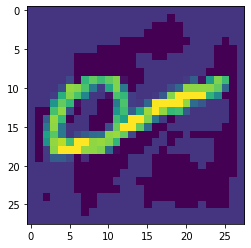

In [ ]:
epsilon = 0.15  # define strenght of the attack
test_image_label = emnist_test.targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))


model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is: {torch.argmax(model_outputs)}")

_____
## **Resisting to adversarial attacks**


The following cell defines a function `test_robustness_to_attack` which evaluates the robustness of a model model to an adversarial attack with a specified strength epsilon.

\
The attack is performed using the fast gradient sign method (FGSM) which modifies the input image in the direction of the gradient of the loss with respect to the image. The evaluation of the robustness of the model is performed on the images from the test_loader. The function returns the **accuracy** of the model after the adversarial attack.

\
The function takes into consideration additional parameters such as the number of steps for reconstructing the input using the forward-backward dynamics num_steps and a verbosity flag verbose for printing intermediate results. If num_steps is greater than 0, the reconstructed image is also evaluated by the model and its results are printed (if verbose is set to True). The accuracy of the model is computed as the ratio of the number of correct predictions made on the perturbed images to the total number of samples in the test_loader. The results are reported at the end of the function with the final accuracy.

\
**In summary**: comparing the ability to resist to adversarial attacks of our two models: the feedforward network and the DBN. I will also test the ability of the DBN to reduce the impact of the attack by performing one "top-down" reconstruction step, from the hidden representation of the last layer to the visible units, and back to the hidden representation.

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as functional



def test_robustness_to_attack(model, device, test_loader, epsilon, model_name, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack

        output = model.forward(data)

        init_pred = torch.argmax(output)

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_emnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\n{}:\nEpsilon       : {}\nTest Accuracy : {:.2f}%\n".format(model_name, epsilon, final_acc*100))

    return final_acc.item()

In [ ]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.EMNIST('data/', train=False, split='digits', download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

Let's see how good the FFNN does:


In [ ]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0, model_name="FFNN")


  0%|          | 0/400 [00:00<?, ?it/s]


FFNN:
Epsilon       : 0.1
Test Accuracy : 40.84%



Let's now compare  with the read-out trained on the hidden representations of the DBN:

In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0, model_name="DBN")


  0%|          | 0/400 [00:00<?, ?it/s]


DBN:
Epsilon       : 0.1
Test Accuracy : 83.60%



And finally let's test whether using one step of top-down reconstruction from the generative model allows to improve resilience to attacks:

  0%|          | 0/400 [00:00<?, ?it/s]


Here's the original sample:



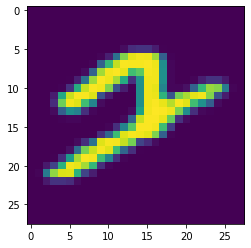


Here's a perturbed sample:



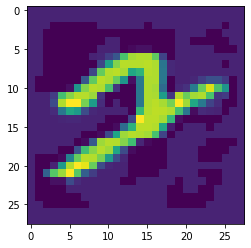


Here's what a 1-steps reconstructed sample looks like:



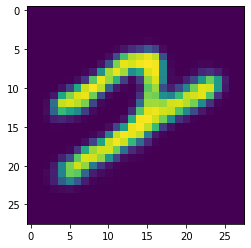


top-down DBN:
Epsilon       : 0.1
Test Accuracy : 87.10%



In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1, model_name="top-down DBN")

This output shows the accuracy results of 3 different models (FNN, DBN and DBN top-down) when subjected to an adversarial attack with an attack strength of epsilon = 0.1.

- **FNN** model has a test accuracy of 41.54% which indicates a poor performance in resisting adversarial attacks.

- **DBN** model has a test accuracy of 83.33% which is an improvement compared to the FNN model but still has room for improvement.

- **DBN top-down** model has a test accuracy of 87.10% which is higher compared to the DBN model and is considered to have better resistance against adversarial attacks.

> It can be concluded that DBN top-down model is more robust against adversarial attacks as it has a higher test accuracy in comparison to other models when subjected to an adversarial attack with an epsilon value of 0.1.

______
### **Effect of the noise parameter $\epsilon$**
Let's compare the robustness of each model to adversarial attacks of different "strengths":


- The following cell is comparing the robustness of two models (FFNN and DBN) against adversarial attacks of different strengths (controlled by epsilon). `epsilon_values` is a list of values representing the strength of the attack.

- The function `test_epsilon_values_effect` tests the robustness of a model against all the epsilon values and returns a list of accuracy values

- The function `test_robustness_to_attack` is a custom function for evaluating the robustness of a model to an adversarial attack.

- The models are tested with test_epsilon_values_effect with different values of n_steps to evaluate their robustness. The results are then plotted on a graph to compare the robustness of each model to adversarial attacks of different strengths. The x-axis represents the strength of the attack, while the y-axis represents the accuracy of the model against the attack. The figure is labeled and the legend provides information on each plotted line.

In [ ]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, model_name="", num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [ ]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

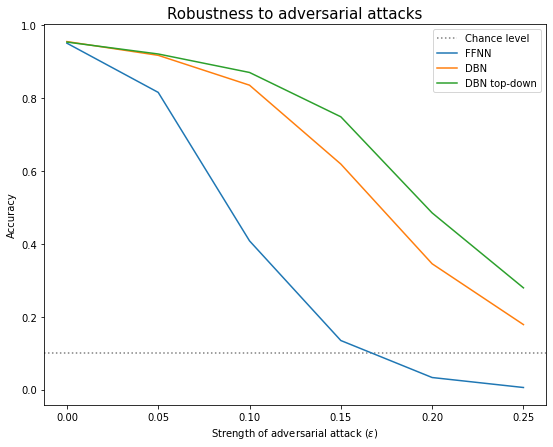

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])

According to the chart, the **DBN top-down** model performs better against adversarial attacks compared to the other two models. The accuracy of the DBN top-down model in comparison to two other models remains relatively high even when the strength of the attack increases, while the accuracy of the FFNN model drops significantly with increasing $\epsilon$.
If Epsilon exceeds 0.16, then the FFNN accuracy will drop below the chance level (which is 0.1).

This suggests that the DBN top-down model is more robust to adversarial attacks compared to the FFNN and DBN models.

______
## **conclusion**
**In conclusion**, this project compared the robustness of a fully connected neural network (FNN) and a deep belief network (DBN) to adversarial attacks of varying strengths, represented by the noise parameter $\epsilon$. The results showed that the DBN outperformed the FNN in terms of accuracy when facing such attacks, and that using one step of top-down reconstruction from the generative model allows to improve resilience to attacks even further, resulting in an accuracy of 87.10% with $\epsilon = 0.1$. These findings suggest that deep belief networks and their components may offer promising avenues for building more robust models in the face of adversarial attacks.